## This model has the following characteristics:
* No feature engineering
* Applying One-hot-Encoding to raw transactions
* Applying Autoencoder to reduce the number of features

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from keras.optimizers import RMSprop
from keras import regularizers
from keras.callbacks import EarlyStopping

### Read Data

In [3]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

df_train.head()

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000


In [4]:
df_train.shape, df_test.shape, y_train.shape

((232004, 7), (163558, 7), (3500,))

### Transform Categorical Data with One-hot Encoding

In [5]:
level = 'gds_grp_nm'

df_all = pd.concat([df_train, df_test])
train1 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test1 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

level = 'gds_grp_mclas_nm'

df_all = pd.concat([df_train, df_test])
train2 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test2 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

level = 'goods_id'

df_all = pd.concat([df_train, df_test])
train3 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test3 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

train = np.hstack([train1, train2, train3])
test = np.hstack([test1, test2, test3])

train.shape, test.shape

((3500, 4179), (2482, 4179))

In [6]:
y_train.shape

(3500,)

### Reduce Dimensionality using Autoencoder

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4179)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2140160   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               3302

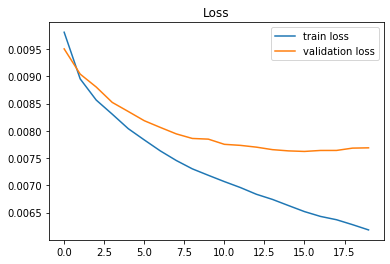

In [6]:
# Define the number of features
max_features = train.shape[1]

# Define the encoder dimension
encoding_dim = 128

# Input Layer
input_dim = Input(shape = (max_features, ))

# Encoder Layers
encoded1 = Dense(512, activation = 'relu')(input_dim)
encoded2 = Dense(256, activation = 'relu')(encoded1)
encoded3 = Dense(128, activation = 'relu')(encoded2)
encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3)

# Decoder Layers
decoded1 = Dense(128, activation = 'relu')(encoded4)
decoded2 = Dense(256, activation = 'relu')(decoded1)
decoded3 = Dense(512, activation = 'relu')(decoded2)
decoded4 = Dense(max_features, activation = 'linear')(decoded3)

# Combine Encoder and Deocder layers
autoencoder = Model(inputs = input_dim, outputs = decoded4)
autoencoder.summary()

# Compile the model
autoencoder.compile(optimizer = 'adam', loss = 'mse')

# Train the model
history = autoencoder.fit(train, train, epochs=20, batch_size=64, 
                          shuffle=True, validation_data=(test,test))

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

In [7]:
# Use a middle Bottleneck Layer to Reduce Dimension
hidden_act = [encoded4] #[encoded1, encoded2, encoded3, decoded1, decoded2]
for ix, act in enumerate(hidden_act):
    model = Model(inputs=input_dim, outputs=act)
    if ix == 0: 
        X_train = model.predict(train)
        X_test = model.predict(test)
    else:
        X_train = np.hstack([X_train, model.predict(train)])
        X_test = np.hstack([X_test, model.predict(test)])
        
X_train.shape, X_test.shape

((3500, 128), (2482, 128))

In [8]:
y_train.shape

(3500,)

### Build Models

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
Train on 2800 samples, validate on 700 samples
Epoch 1/100
2800/2800 [==============================] - 0s 134us/step 

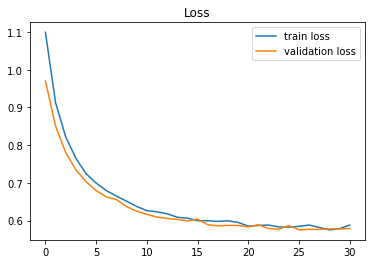

In [9]:
# Define the number of features
max_features = X_train.shape[1]

# Define the Model architecture
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(max_features,), kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()

# Train the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=100, batch_size=64, 
                    validation_split=0.2, callbacks=[EarlyStopping(patience=5)])

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

### Make Submissions

In [ ]:
pred = model.predict(X_test)[:,0]
fname = 'submissions.csv'
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print("'{}' is ready to submit." .format(fname))

## End